HOMEWORK 4

Q1

In [293]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn import tree
from math import log
from sklearn.tree import DecisionTreeClassifier

In [203]:
d={'age':[24,53,23,25,52,32,22,43,52,48],'salary':[40000,52000,25000,77000,48000,110000,38000,44000,27000,65000],'degree':['Yes','No','No','Yes','Yes','Yes','Yes','No','No','Yes']}

In [204]:
df = pd.DataFrame(data=d)

In [205]:
df

,age,salary,degree
0,24,40000,Yes
1,53,52000,No
2,23,25000,No
3,25,77000,Yes
4,52,48000,Yes
5,32,110000,Yes
6,22,38000,Yes
7,43,44000,No
8,52,27000,No
9,48,65000,Yes


<AxesSubplot:xlabel='age', ylabel='salary'>

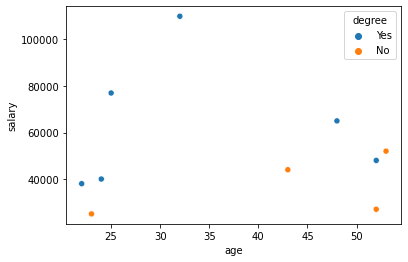

In [206]:
sns.scatterplot(x='age',y='salary',data=df,hue='degree')

In [275]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [276]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [277]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [278]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_0 <= 15 ? 0.016656144298943854
 left:X_1 <= 7472 ? 0.016114028071516573
  left:X_8 <= 0 ? 0.01237371997188419
    left:X_7 <= 0 ? 0.010105262997751385
        left:0
        right:1
    right:X_33 <= 0 ? 0.2668253968253968
        left:1
        right:0
  right:1
 right:X_12 <= 0 ? 0.02848314687807596
  left:X_20 <= 0 ? 0.0091426066322009
    left:X_13 <= 0 ? 0.01862874779541429
        left:0
        right:0
    right:X_0 <= 39 ? 0.022356547702169827
        left:0
        right:0
  right:X_0 <= 42 ? 0.025468753624126705
    left:X_1 <= 8133 ? 0.02619879764321409
        left:0
        right:1
    right:X_3 <= 1 ? 0.14515686453855287
        left:0
        right:1


In [279]:
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.685

The depth of the tree is 4

The information gain at each step is given in the diagram above. It is the value next to the question mark.

Multivariate decision trees have practical advantages and disadvantage. List advantages and disadvantages you can think of when comparing multivariate decision trees to univariate decision trees.

Moreover, the tests in the univariate decision trees are pre-formed sequentially by following the branches of the tree, thus only those features that are required to reach a decision are evaluated. This results in more nodes than univariate tree but at the same time the complexity of the tree is far less than a multivariate tree with fewer nodes and branches.

In [326]:
class Node:
    def __init__(self, features, target):
        self.left = None 
        self.right = None
        self.features = features
        self.target = target 
        self.feature_types = self.select_dtype()
        
    # Identiy feature types
    def select_dtype(self):
        feature_types = []
        for item in self.features.columns:
            if self.features[item].dtype != "O":
                feature_types.append((item, "numerical")) 
            else:
                if self.features[item].nunique() <= 2:
                    feature_types.append((item, "binary"))
                else:
                    feature_types.append((item, "multiclass"))
        return feature_types
    
    # Calculate gini impurity for each feature at a node
    # Need to provide a default value as a fallback 
    @staticmethod
    def gini_impurity_total(a=0, b=0, c=0, d=0):
        total_elements = a + b + c + d
        gini_1 = 1 - np.square(a/(a+b)) - np.square(b/(a+b))
        gini_2 = 1 - np.square(c/(c+d)) - np.square(d/(c+d))
        total_gini = ((a+b)/total_elements) * gini_1 + ((c+d)/total_elements) * gini_2
        return total_gini 
    
    @staticmethod
    def gini_impurity(a=0, b=0):
        return 1 - np.square(a/(a+b)) - np.square(b/(a+b))
    
    # Calculate gini for all feature combinations in categorical features
    def calculate_gini(self, feature):
        gini_node = []
        combinations = []
        
        for i in range(1, self.features[feature].nunique()):
            combinations = combinations + list(itertools.combinations(self.features[feature].unique(), i))
            
        for item in combinations:
            t1 = self.target[self.features[feature].isin(item)] 
            t2 = self.target[~self.features[feature].isin(item)]
            args = t1.value_counts().tolist() + t2.value_counts().tolist()
            gini_node.append(Node.gini_impurity_total(*args))
        
        return gini_node, combinations # Return all the values 

In [331]:
def evaluate_node(self):
    gini_values = []
    for feature in self.features.columns:
        calculated_gini, combinations = self.calculate_gini(feature)
        best_combination = combinations[np.argmin(calculated_gini)]
        gini_values.append((feature, best_combination, np.min(calculated_gini)))
    return gini_values
                
    # Inserting a new node based on the decision criteria
def insert_node(self):
    gini_values = self.evaluate_node()
    values = [item[2] for item in gini_values]
    node_gini =  Node.gini_impurity(*self.target.value_counts().tolist())
        
         # Terminate the branch if current gini is better or no features to split
    if node_gini < np.min(values): 
        print("terminating the branch")
        self.left = None
        self.right = None 
    else:
        best_feature = gini_values[np.argmin(values)][0]
        best_combination = gini_values[np.argmin(values)][1]
        print(f"Creating a new branch using {best_feature} and {best_combination}")

        left_features = self.features[self.features[best_feature].isin(best_combination)]
        left_features.drop([best_feature], axis=1, inplace=True)
        left_target = self.target[self.features[best_feature].isin(best_combination)]
        if list(left_features.columns) == []:
            self.left = None 
            self.right = None
        else:
            self.left = Node(left_features, left_target)
            self.left.insert_node()

        right_features = self.features[~self.features[best_feature].isin(best_combination)]
        right_target = self.target[~self.features[best_feature].isin(best_combination)]
        right_features.drop([best_feature], axis=1, inplace=True)
        if list(right_features.columns) == []:
            self.left = None 
            self.right = None
        else:
            self.right = Node(right_features, right_target)
            self.right.insert_node()

# Creating the root node with the full dataset 
    root = Node(features, target)

# Building the tree 
    root.insert_node()

The 3rd part of the question is mentioned in the pdf attached where we see adv and disadv of univariate and multivariate learning processes.

I have also attached a well drawn tree for both the cases.

Q2 

Implementing AdaBoost on the 1st Dataset

In [282]:
data=pd.read_csv('letter-recognition.data')

In [283]:
data.head()

,T,2,8,3,5,1,8.1,13,0,6,6.1,10,8.2,0.1,8.3,0.2,8.4
0,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
1,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
2,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
3,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
4,S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7


In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T       19999 non-null  object
 1   2       19999 non-null  int64 
 2   8       19999 non-null  int64 
 3   3       19999 non-null  int64 
 4   5       19999 non-null  int64 
 5   1       19999 non-null  int64 
 6   8.1     19999 non-null  int64 
 7   13      19999 non-null  int64 
 8   0       19999 non-null  int64 
 9   6       19999 non-null  int64 
 10  6.1     19999 non-null  int64 
 11  10      19999 non-null  int64 
 12  8.2     19999 non-null  int64 
 13  0.1     19999 non-null  int64 
 14  8.3     19999 non-null  int64 
 15  0.2     19999 non-null  int64 
 16  8.4     19999 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [285]:
data.describe()

,2,8,3,5,1,8.1,13,0,6,6.1,10,8.2,0.1,8.3,0.2,8.4
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.00000
mean,4.023651,7.035452,5.121956,5.372469,3.505975,6.897545,7.500175,4.628831,5.178609,8.282164,6.453823,7.928996,3.046252,8.338867,3.691935,7.80119
std,1.913206,3.304631,2.014568,2.261445,2.190441,2.026071,2.325087,2.699837,2.380875,2.488485,2.631016,2.080671,2.332500,1.546759,2.567004,1.61751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.000000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.000000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.000000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.000000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.000000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.000000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000


In [286]:
data.columns=['lettr','x-box','y-box','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']

In [287]:
data.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
1,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
2,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
3,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
4,S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7


In [288]:
dat = data[(data['lettr'] == 'C') | (data['lettr'] == 'G')]

In [289]:
dat['Label'] = dat['lettr'].replace(to_replace = ['C','G'], value=[1,0])

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [290]:
example=dat.copy()

In [294]:
def adaboost1(example, rounds):
    seed_val = 10
    alpha_list = []
    a=[]
    example['prob1'] = 1/(example.shape[0])
    for i in range(rounds):
        seed_val = seed_val+i*seed_val
        random.seed(seed_val)
        example1 = example.sample(len(example), replace = True, weights = example['prob'+str(i+1)])
        #example1 = example1.iloc[:,0:58]
        X_train = example1.iloc[0:500,1:17]
        y_train = example1.iloc[0:500,17]
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=1)
        clf = clf_gini.fit(X_train, y_train)
        y_pred = clf_gini.predict(example.iloc[0:len(dat),1:17])
        example['pred'+str(i+1)] = y_pred
        #print(example.head())
        tree.plot_tree(clf)
        
        example.loc[example.Label != example['pred'+str(i+1)], 'misclassified'] = 1
        example.loc[example.Label == example['pred'+str(i+1)], 'misclassified'] = 0
        
        e1 = sum(example['misclassified'] * example['prob'+str(i+1)])
        a.append(e1)
        alpha1 = 0.5*log((1-e1)/e1)
        #storing alpha vals into a list for each seed
        alpha_list.append(alpha1)
        
        new_weight = example['prob'+str(i+1)]*np.exp(-1*alpha1*example['Label']*example['pred'+str(i+1)])
        z = sum(new_weight)
        normalized_weight = new_weight/sum(new_weight)
        example['prob'+str(i+2)] = round(normalized_weight,4)
        
    t = 0
    for i in range(len(alpha_list)):
        t+=alpha_list[i]*example['pred'+str(i+1)]

    example['final_pred'] = np.sign(list(t))

    c = confusion_matrix(example['Label'], example['final_pred'])
    
    #sns.scatterplot(x=[1,2,3,4],y=a)
    #print(c)
    return (c[0,0]+c[1,1])/np.sum(c)*100

77.20344599072233

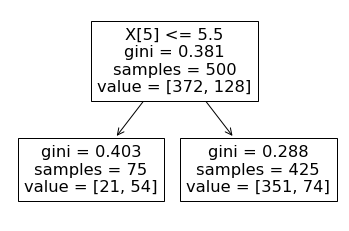

In [295]:
adaboost1(example,4)

<AxesSubplot:>

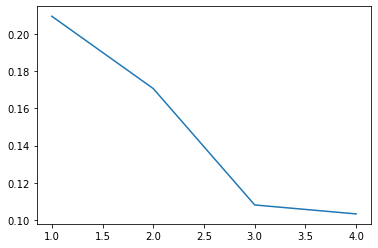

In [227]:
sns.lineplot(x=[1,2,3,4],y=a)

In [296]:
def adaboost1(example, rounds):
    seed_val = 10
    alpha_list = []
    a=[]
    example['prob1'] = 1/(example.shape[0])
    for i in range(rounds):
        seed_val = seed_val+i*seed_val
        random.seed(seed_val)
        example1 = example.sample(len(example), replace = True, weights = example['prob'+str(i+1)])
        #example1 = example1.iloc[:,0:58]
        X_train = example1.iloc[0:500,1:17]
        y_train = example1.iloc[0:500,17]
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
        clf = clf_gini.fit(X_train, y_train)
        y_pred = clf_gini.predict(example.iloc[0:len(dat),1:17])
        example['pred'+str(i+1)] = y_pred
        #print(example.head())
        tree.plot_tree(clf)
        
        example.loc[example.Label != example['pred'+str(i+1)], 'misclassified'] = 1
        example.loc[example.Label == example['pred'+str(i+1)], 'misclassified'] = 0
        
        e1 = sum(example['misclassified'] * example['prob'+str(i+1)])
        a.append(e1)
        alpha1 = 0.5*log((1-e1)/e1)
        #storing alpha vals into a list for each seed
        alpha_list.append(alpha1)
        
        new_weight = example['prob'+str(i+1)]*np.exp(-1*alpha1*example['Label']*example['pred'+str(i+1)])
        z = sum(new_weight)
        normalized_weight = new_weight/sum(new_weight)
        example['prob'+str(i+2)] = round(normalized_weight,4)
        
    t = 0
    for i in range(len(alpha_list)):
        t+=alpha_list[i]*example['pred'+str(i+1)]

    example['final_pred'] = np.sign(list(t))

    c = confusion_matrix(example['Label'], example['final_pred'])
    
    #sns.scatterplot(x=[1,2,3,4],y=a)
    #print(c)
    return (c[0,0]+c[1,1])/np.sum(c)*100

92.97548045062956

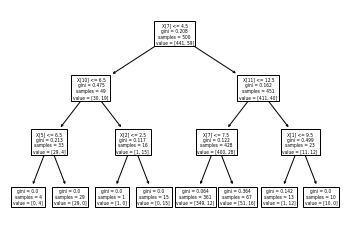

In [297]:
adaboost1(example,4)

We see how test error is decreasng with each iteration.

In [228]:
dat.drop('lettr',axis=1,inplace=True)

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [229]:
X=dat.iloc[0:len(dat),0:16]
y=dat.iloc[0:len(dat),16]

In [230]:
import numpy as np
from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [231]:
class BaggedTreeClassifier(object):
    #initializer
    def __init__(self,n_elements=100):
        self.n_elements = n_elements
        self.models     = []
    
    #destructor
    def __del__(self):
        del self.n_elements
        del self.models
        
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_elements):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)
    
    def get_params(self, deep = False):
        return {'n_elements':self.n_elements}
    
    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #package the input data
        training_data = np.concatenate((X_train,y_train.values.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #initialise metric arrays
        accs = np.array([])
        pres = np.array([])
        recs = np.array([])
        #iterate through each bootstrap sample & fit a model ##
        cls = DecisionTreeClassifier(class_weight='balanced')
        for b in dcBoot:
            #make a clone of the model
            model = clone(cls)
            #fit a decision tree classifier to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.models.append(model)
            #compute the predictions on the out-of-bag test set & compute metrics
            if dcBoot[b]['test'].size:
                yp  = model.predict(dcBoot[b]['test'][:,:-1])
                acc = accuracy_score(dcBoot[b]['test'][:,-1],yp)
                pre = precision_score(dcBoot[b]['test'][:,-1],yp,average='micro')   
                rec = recall_score(dcBoot[b]['test'][:,-1],yp,average='micro')
                #store the error metrics
                accs = np.concatenate((accs,acc.flatten()))
                pres = np.concatenate((pres,pre.flatten()))
                recs = np.concatenate((recs,rec.flatten()))
        #compute standard errors for error metrics
        if print_metrics:
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))
            
    
    #predict from the ensemble
    def predict(self,X):
        #check we've fit the ensemble
        if not self.models:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.models:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.round(np.mean(np.concatenate(predictions,axis=1),axis=1)).astype(int)
        #return the prediction
        return(ypred)

In [232]:
b=BaggedTreeClassifier()
b.fit(X,y,print_metrics=True)

Standard error in accuracy: 0.01
Standard error in precision: 0.01
Standard error in recall: 0.01


In [233]:
clf = BaggedTreeClassifier()
clf.fit(X,y,print_metrics=True)

Standard error in accuracy: 0.01
Standard error in precision: 0.01
Standard error in recall: 0.01


In [234]:
scoring_metrics = ['accuracy','precision','recall']
dcScores        = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.97
Mean Precision: 0.98
Mean Recall: 0.96


We clearly see bagging outperforming boosting in this case.

It gets a better accuracy by a good 15%. Bagging depends on lots of decision tress unlike boosting which mainly works on slumps.

But when we increase depth of tree to 3 the accuracy increases to 91% thus we see how depth and slumps affect the tree on a particular dataset.

Now lets check for second dataset

We will first implement boosting here

In [298]:
data2=pd.read_csv('german.csv',sep=' ')
data2.columns=['StatusCheckingAcc','Duration(month)','CreditHistory','Purpose','CreditAmount','SavingAcc','PresentEmpSince','InstallmentRatePct','Status/Sex','Debtors/Gurantee','PresentResidenceYr','Property','Age','InstallmentPlans','Housing','NumExistingCredit','Job','Liabilties','Telephone','ForeignWorker','Label']

In [299]:
data2.head()

,StatusCheckingAcc,Duration(month),CreditHistory,Purpose,CreditAmount,SavingAcc,PresentEmpSince,InstallmentRatePct,Status/Sex,Debtors/Gurantee,...,Property,Age,InstallmentPlans,Housing,NumExistingCredit,Job,Liabilties,Telephone,ForeignWorker,Label
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
2,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
3,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
4,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1


In [300]:
df=data2.copy()

In [301]:
df.drop(['StatusCheckingAcc','Telephone','InstallmentPlans','Status/Sex','Purpose'],axis=1,inplace=True)

In [302]:
df = pd.get_dummies(df, columns=['CreditHistory','SavingAcc','PresentEmpSince','Debtors/Gurantee','Property','Housing','Job','ForeignWorker'])

In [303]:
df['Labels'] = df['Label'].replace(to_replace = [1,2], value=[0,1])

In [304]:
df.drop('Label',axis=1,inplace=True)

In [305]:
example=df.copy()

In [306]:
def adaboost2(example, rounds):
    seed_val = 10
    alpha_list = []
    a=[]
    example['prob1'] = 1/(example.shape[0])
    for i in range(rounds):
        seed_val = seed_val+i*seed_val
        random.seed(seed_val)
        example1 = example.sample(len(example), replace = True, weights = example['prob'+str(i+1)])
        #example1 = example1.iloc[:,0:58]
        X_train = example1.iloc[0:500,0:38]
        y_train = example1.iloc[0:500,38]
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=1)
        clf = clf_gini.fit(X_train, y_train)
        y_pred = clf_gini.predict(example.iloc[0:len(df),0:38])
        example['pred'+str(i+1)] = y_pred
        #print(example.head())
        tree.plot_tree(clf)
        
        example.loc[example.Labels != example['pred'+str(i+1)], 'misclassified'] = 1
        example.loc[example.Labels == example['pred'+str(i+1)], 'misclassified'] = 0
        
        e1 = sum(example['misclassified'] * example['prob'+str(i+1)])
        a.append(e1)
        alpha1 = 0.5*log((1-e1)/e1)
        #storing alpha vals into a list for each seed
        alpha_list.append(alpha1)
        
        new_weight = example['prob'+str(i+1)]*np.exp(-1*alpha1*example['Labels']*example['pred'+str(i+1)])
        z = sum(new_weight)
        normalized_weight = new_weight/sum(new_weight)
        example['prob'+str(i+2)] = round(normalized_weight,4)
        
    t = 0
    for i in range(len(alpha_list)):
        t+=alpha_list[i]*example['pred'+str(i+1)]

    example['final_pred'] = np.sign(list(t))

    c = confusion_matrix(example['Labels'], example['final_pred'])
    #print(c)
    return (c[0,0]+c[1,1])/np.sum(c)*100

69.26926926926927

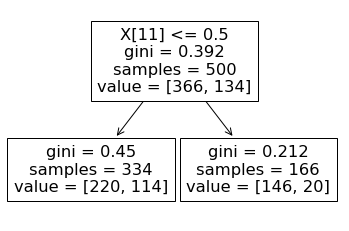

In [307]:
adaboost2(example,4)

<AxesSubplot:>

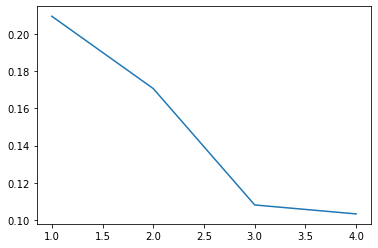

In [308]:
sns.lineplot(x=[1,2,3,4],y=a)

In [309]:
def adaboost2(example, rounds):
    seed_val = 10
    alpha_list = []
    a=[]
    example['prob1'] = 1/(example.shape[0])
    for i in range(rounds):
        seed_val = seed_val+i*seed_val
        random.seed(seed_val)
        example1 = example.sample(len(example), replace = True, weights = example['prob'+str(i+1)])
        #example1 = example1.iloc[:,0:58]
        X_train = example1.iloc[0:500,0:38]
        y_train = example1.iloc[0:500,38]
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
        clf = clf_gini.fit(X_train, y_train)
        y_pred = clf_gini.predict(example.iloc[0:len(df),0:38])
        example['pred'+str(i+1)] = y_pred
        #print(example.head())
        tree.plot_tree(clf)
        
        example.loc[example.Labels != example['pred'+str(i+1)], 'misclassified'] = 1
        example.loc[example.Labels == example['pred'+str(i+1)], 'misclassified'] = 0
        
        e1 = sum(example['misclassified'] * example['prob'+str(i+1)])
        a.append(e1)
        alpha1 = 0.5*log((1-e1)/e1)
        #storing alpha vals into a list for each seed
        alpha_list.append(alpha1)
        
        new_weight = example['prob'+str(i+1)]*np.exp(-1*alpha1*example['Labels']*example['pred'+str(i+1)])
        z = sum(new_weight)
        normalized_weight = new_weight/sum(new_weight)
        example['prob'+str(i+2)] = round(normalized_weight,4)
        
    t = 0
    for i in range(len(alpha_list)):
        t+=alpha_list[i]*example['pred'+str(i+1)]

    example['final_pred'] = np.sign(list(t))

    c = confusion_matrix(example['Labels'], example['final_pred'])
    #print(c)
    return (c[0,0]+c[1,1])/np.sum(c)*100

67.26726726726727

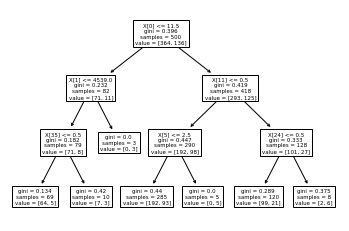

In [310]:
adaboost2(example,4)

In [246]:
X=df.iloc[0:len(df),0:38]
y=df.iloc[0:len(df),38]

In [247]:
class BaggedTreeClassifier(object):
    #initializer
    def __init__(self,n_elements=100):
        self.n_elements = n_elements
        self.models     = []
    
    #destructor
    def __del__(self):
        del self.n_elements
        del self.models
        
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_elements):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)
    
    def get_params(self, deep = False):
        return {'n_elements':self.n_elements}
    
    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #package the input data
        training_data = np.concatenate((X_train,y_train.values.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #initialise metric arrays
        accs = np.array([])
        pres = np.array([])
        recs = np.array([])
        #iterate through each bootstrap sample & fit a model ##
        cls = DecisionTreeClassifier(class_weight='balanced')
        for b in dcBoot:
            #make a clone of the model
            model = clone(cls)
            #fit a decision tree classifier to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.models.append(model)
            #compute the predictions on the out-of-bag test set & compute metrics
            if dcBoot[b]['test'].size:
                yp  = model.predict(dcBoot[b]['test'][:,:-1])
                acc = accuracy_score(dcBoot[b]['test'][:,-1],yp)
                pre = precision_score(dcBoot[b]['test'][:,-1],yp,average='micro')   
                rec = recall_score(dcBoot[b]['test'][:,-1],yp,average='micro')
                #store the error metrics
                accs = np.concatenate((accs,acc.flatten()))
                pres = np.concatenate((pres,pre.flatten()))
                recs = np.concatenate((recs,rec.flatten()))
        #compute standard errors for error metrics
        if print_metrics:
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))
            
    
    #predict from the ensemble
    def predict(self,X):
        #check we've fit the ensemble
        if not self.models:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.models:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.round(np.mean(np.concatenate(predictions,axis=1),axis=1)).astype(int)
        #return the prediction
        return(ypred)

In [248]:
b=BaggedTreeClassifier()
b.fit(X,y,print_metrics=True)

Standard error in accuracy: 0.02
Standard error in precision: 0.02
Standard error in recall: 0.02


In [249]:
clf = BaggedTreeClassifier()
clf.fit(X,y,print_metrics=True)
scoring_metrics = ['accuracy','precision','recall']
dcScores        = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Standard error in accuracy: 0.03
Standard error in precision: 0.03
Standard error in recall: 0.03
Mean Accuracy: 0.74
Mean Precision: 0.62
Mean Recall: 0.31


In the case of credit card dataset we see bagging performing slightly better than boosting. The dataset contains lots of qualitative variables and changing them to dummies increases correlation and we get a relatively average accruacy of about 70 in both the cases.

We see in this dataset increasing the depth of tree doesn't improve the accuracy of the dataset it is mainly due to the high correlation with in the data due to creation of dummy variables.

Now lets check for the 3rd dataset

We will start with boosting

In [311]:
data4=pd.read_csv('spambase.data',sep=',')

In [312]:
data4.columns=['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove',
'word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report',
'word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your',
'word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab',
'word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999',
'word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project',
'word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!',
'char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest','capital_run_length_total','spam'] 

In [313]:
data4.shape

(4600, 58)

In [314]:
data4.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [315]:
example=data4.copy()

In [316]:
def adaboost(example, rounds):
    seed_val = 10
    alpha_list = []
    a=[]
    example['prob1'] = 1/(example.shape[0])
    for i in range(rounds):
        seed_val = seed_val+i*seed_val
        random.seed(seed_val)
        example1 = example.sample(len(example), replace = True, weights = example['prob'+str(i+1)])
        #example1 = example1.iloc[:,0:58]
        X_train = example1.iloc[0:len(data4),0:57]
        y_train = example1.iloc[0:len(data4),57]
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=1)
        clf = clf_gini.fit(X_train, y_train)
        y_pred = clf_gini.predict(example.iloc[0:len(data4),0:57])
        example['pred'+str(i+1)] = y_pred
        #print(example.head())
        tree.plot_tree(clf)
        
        example.loc[example.spam != example['pred'+str(i+1)], 'misclassified'] = 1
        example.loc[example.spam == example['pred'+str(i+1)], 'misclassified'] = 0
        
        e1 = sum(example['misclassified'] * example['prob'+str(i+1)])
        a.append(e1)
        alpha1 = 0.5*log((1-e1)/e1)
        #storing alpha vals into a list for each seed
        alpha_list.append(alpha1)
        
        new_weight = example['prob'+str(i+1)]*np.exp(-1*alpha1*example['spam']*example['pred'+str(i+1)])
        z = sum(new_weight)
        normalized_weight = new_weight/sum(new_weight)
        example['prob'+str(i+2)] = round(normalized_weight,4)
        
    t = 0
    for i in range(len(alpha_list)):
        t+=alpha_list[i]*example['pred'+str(i+1)]

    example['final_pred'] = np.sign(list(t))

    c = confusion_matrix(example['spam'], example['final_pred'])
    #print(c)
    return (c[0,0]+c[1,1])/np.sum(c)*100

80.82608695652173

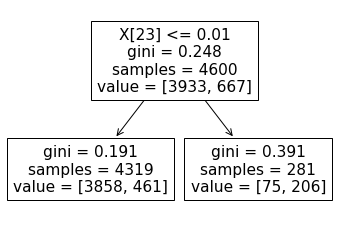

In [317]:
adaboost(example,4)

<AxesSubplot:>

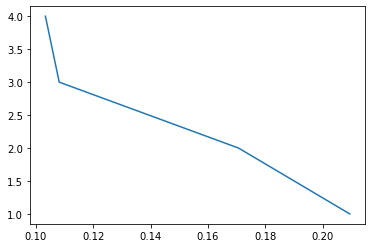

In [318]:
sns.lineplot(x=a,y=[1,2,3,4])

This is how with each iteration the test error reduces

In [319]:
def adaboost(example, rounds):
    seed_val = 10
    alpha_list = []
    a=[]
    example['prob1'] = 1/(example.shape[0])
    for i in range(rounds):
        seed_val = seed_val+i*seed_val
        random.seed(seed_val)
        example1 = example.sample(len(example), replace = True, weights = example['prob'+str(i+1)])
        #example1 = example1.iloc[:,0:58]
        X_train = example1.iloc[0:len(data4),0:57]
        y_train = example1.iloc[0:len(data4),57]
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
        clf = clf_gini.fit(X_train, y_train)
        y_pred = clf_gini.predict(example.iloc[0:len(data4),0:57])
        example['pred'+str(i+1)] = y_pred
        #print(example.head())
        tree.plot_tree(clf)
        
        example.loc[example.spam != example['pred'+str(i+1)], 'misclassified'] = 1
        example.loc[example.spam == example['pred'+str(i+1)], 'misclassified'] = 0
        
        e1 = sum(example['misclassified'] * example['prob'+str(i+1)])
        a.append(e1)
        alpha1 = 0.5*log((1-e1)/e1)
        #storing alpha vals into a list for each seed
        alpha_list.append(alpha1)
        
        new_weight = example['prob'+str(i+1)]*np.exp(-1*alpha1*example['spam']*example['pred'+str(i+1)])
        z = sum(new_weight)
        normalized_weight = new_weight/sum(new_weight)
        example['prob'+str(i+2)] = round(normalized_weight,4)
        
    t = 0
    for i in range(len(alpha_list)):
        t+=alpha_list[i]*example['pred'+str(i+1)]

    example['final_pred'] = np.sign(list(t))

    c = confusion_matrix(example['spam'], example['final_pred'])
    #print(c)
    return (c[0,0]+c[1,1])/np.sum(c)*100

88.82608695652175

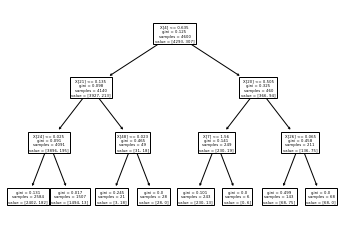

In [320]:
adaboost(example,4)

NOW BAGGING 

In [258]:
data4.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [259]:
example.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,pred1,misclassified,prob2,pred2,prob3,pred3,prob4,pred4,prob5,final_pred
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,1,0.0,0.0001,1,0.0001,1,0.0001,1,0.0000,1.0
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,1,1.0,0.0001,1,0.0001,1,0.0001,0,0.0001,1.0
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0,0.0,0.0002,1,0.0001,1,0.0001,1,0.0000,1.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0,0.0,0.0002,1,0.0001,1,0.0001,1,0.0000,1.0
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0,1.0,0.0002,0,0.0003,0,0.0003,0,0.0003,0.0


In [260]:
X=data4.iloc[0:len(data4),0:57]
y=data4.iloc[0:len(data4),57]

In [261]:
class BaggedTreeClassifier(object):
    #initializer
    def __init__(self,n_elements=100):
        self.n_elements = n_elements
        self.models     = []
    
    #destructor
    def __del__(self):
        del self.n_elements
        del self.models
        
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_elements):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)
    
    def get_params(self, deep = False):
        return {'n_elements':self.n_elements}
    
    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #package the input data
        training_data = np.concatenate((X_train,y_train.values.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #initialise metric arrays
        accs = np.array([])
        pres = np.array([])
        recs = np.array([])
        #iterate through each bootstrap sample & fit a model ##
        cls = DecisionTreeClassifier(class_weight='balanced')
        for b in dcBoot:
            #make a clone of the model
            model = clone(cls)
            #fit a decision tree classifier to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.models.append(model)
            #compute the predictions on the out-of-bag test set & compute metrics
            if dcBoot[b]['test'].size:
                yp  = model.predict(dcBoot[b]['test'][:,:-1])
                acc = accuracy_score(dcBoot[b]['test'][:,-1],yp)
                pre = precision_score(dcBoot[b]['test'][:,-1],yp,average='micro')   
                rec = recall_score(dcBoot[b]['test'][:,-1],yp,average='micro')
                #store the error metrics
                accs = np.concatenate((accs,acc.flatten()))
                pres = np.concatenate((pres,pre.flatten()))
                recs = np.concatenate((recs,rec.flatten()))
        #compute standard errors for error metrics
        if print_metrics:
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))
            
    
    #predict from the ensemble
    def predict(self,X):
        #check we've fit the ensemble
        if not self.models:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.models:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.round(np.mean(np.concatenate(predictions,axis=1),axis=1)).astype(int)
        #return the prediction
        return(ypred)

In [262]:
b.fit(X,y,print_metrics=True)

Standard error in accuracy: 0.01
Standard error in precision: 0.01
Standard error in recall: 0.01


In [263]:
clf = BaggedTreeClassifier()
clf.fit(X,y,print_metrics=True)
scoring_metrics = ['accuracy','precision','recall']
dcScores        = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Standard error in accuracy: 0.01
Standard error in precision: 0.01
Standard error in recall: 0.01
Mean Accuracy: 0.93
Mean Precision: 0.92
Mean Recall: 0.90


Here we witness again how bagging out perfroms boosting with ease and by a good margin of 10%.

But if we increase the depth of the tree to 3 and apply boosting it performs as good as bagging.

In conclusion, if the difficulty of the single model is over-fitting, then Bagging is the best option. Boosting for its part doesn’t help to avoid over-fitting; in fact, this technique is faced with this problem itself. For this reason, Bagging is effective more often than Boosting and especially in the kind of datasets we have.

When bagging with decision trees, we are less concerned about individual trees overfitting the training data. For this reason and for efficiency, the individual decision trees are grown deep (e.g. few training samples at each leaf-node of the tree) and the trees are not pruned. These trees will have both high variance and low bias. These are important characteristics of sub-models when combining predictions using bagging.

We saw in all 3 datasets how bagging , boosting and boosting with more depth can affect the accuracy of the data. The greater impact of the technique always depends on the type of dataset you have.